<a href="https://colab.research.google.com/github/chrispoole70/langchain-tutorials/blob/main/rag/rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This tutorial is called [Build a Retrieval Augmented Generation (RAG) App: Part 1](https://python.langchain.com/docs/tutorials/rag/)

In [ ]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

In [ ]:
%pip install -qU "langchain[openai]"

In [ ]:
%pip install -qU langchain-core

In [85]:
import os
from typing import Literal
from typing_extensions import List, TypedDict, Annotated

import bs4
from google.colab import userdata
from langchain import hub
from langchain.chat_models import init_chat_model
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph

In [60]:
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

Create the chat model

In [62]:
chat_model = init_chat_model(model='gpt-4o-mini', model_provider='openai')

Create the embeddings model

In [63]:
embeddings_model = OpenAIEmbeddings(model='text-embedding-3-small')

Create the vector store

In [64]:
vector_store = InMemoryVectorStore(embedding=embeddings_model)

### Indexing

1. Load the data using a `DocumentLoader`

In [65]:
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)

And save the data as `Documents`

In [66]:
documents = loader.load()

In [19]:
len(documents)

1

In [22]:
documents[0].page_content[:100]

'\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |'

2. Split the large `Document` into smaller chunks using a `TextSplitter`

In [67]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(documents=documents)

In [25]:
len(all_splits)

63

In [26]:
all_splits[0].page_content

'LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory'

3. Store the splits in a vector store for retrieval later

In [68]:
vector_ids = vector_store.add_documents(documents=all_splits)

In [81]:
len(vector_ids)

63

In [29]:
vector_ids[0]

'a27eb48a-840b-45be-9a49-e0a57ed3eb1f'

In [38]:
len(vector_store.store[vector_ids[0]]['vector'])

1536

In [35]:
vector_store.store[vector_ids[0]]['vector'][:10]

[0.009621397592127323,
 0.020369814708828926,
 0.04163011163473129,
 -0.0041741421446204185,
 0.003499322570860386,
 0.001913148444145918,
 -0.01448427326977253,
 0.036732450127601624,
 -0.019048001617193222,
 0.05882757529616356]

In [39]:
len(vector_store.store[vector_ids[0]]['text'])

969

In [37]:
vector_store.store[vector_ids[0]]['text']

'LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory'

### Create the RAG application

Start by creating a prompt template

In [69]:
prompt_template = hub.pull('rlm/rag-prompt')

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [70]:
prompt_template

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

Define the state for the RAG app

In [71]:
class State(TypedDict):
  context: List[Document]
  question: str
  answer: str

### Retrieval and Generation

4. Retrieve the splits relevant to a user's question

In [72]:
def retrieve(state: State):
  relevant_splits = vector_store.similarity_search(state['question'])
  return {'context': relevant_splits}

In [73]:
def generate(state: State):
  joined_splits = '\n\n'.join(split.page_content for split in state['context'])
  prompt = prompt_template.invoke(
      {
          'context': joined_splits,
          'question': state['question']
      }
  )
  response = chat_model.invoke(input=prompt)
  return {'answer': response.content}

Create the graph

In [53]:
graph_builder = StateGraph(state_schema=State)
graph_builder.add_sequence([retrieve, generate])
graph_builder.add_edge(start_key=START, end_key='retrieve')

graph = graph_builder.compile()

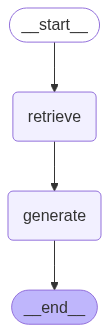

In [54]:
graph

Now you can ask a question by passing it to the graph

In [55]:
response = graph.invoke(input={'question': 'What is Task Decomposition?'})

In [58]:
response

{'context': [Document(id='9448704e-4938-4867-ae1b-84a934d42fa1', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool, assuming the avai

## Query Analysis

Use a technique called query analysis to optimize queries such as retrieving relevant data from the beginning, middle, or end of the blog post

In [75]:
number_of_splits = len(all_splits)
number_of_splits

63

In [77]:
third_of_splits = number_of_splits // 3
third_of_splits

21

In [78]:
for i, split in enumerate(all_splits):
  if i < third_of_splits:
    split.metadata['section'] = 'beginning'
  elif i < third_of_splits * 2:
    split.metadata['section'] = 'middle'
  else:
    split.metadata['section'] = 'end'

In [79]:
all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'section': 'beginning'}

In [84]:
vector_store.store[vector_ids[0]]['metadata']

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'section': 'beginning'}

Define a structured output schema for the LLM to use to help it generate an optimal query for retreival

In [86]:
class Search(TypedDict):
  """Search query."""
  query: Annotated[str, ..., 'Search query to run.']
  section: Annotated[
      Literal['beginning', 'middle', 'end'],
      ...,
      'Section to query.'
  ]

'Search query.'

Update the state schema to include the output schema for the query

In [90]:
class State(TypedDict):
  context: List[Document]
  query: Search
  question: str
  answer: str

Use the LLM to generate the optimized query

In [91]:
def analyze_query(state: State):
  structured_chat_model = chat_model.with_structured_output(schema=Search)
  query = structured_chat_model.invoke(input={state['question']})
  return {'query': query}

Update the `retrieve` function to filter for splits in the specified section of the blog

In [95]:
def retrieve(state: State):
  query = state['query']
  relevant_splits = vector_store.similarity_search(
      query=query['query'],
      filter=lambda split: split.metadata['section'] == query['section']
  )
  return {'context': relevant_splits}

In [93]:
graph_builder = StateGraph(state_schema=State)
graph_builder.add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(start_key=START, end_key='analyze_query')

graph = graph_builder.compile()

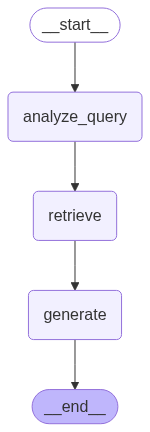

In [94]:
graph

In [98]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="values",
):
    print(f"{step}\n\n----------------\n")

ValueError: Invalid input type <class 'set'>. Must be a PromptValue, str, or list of BaseMessages.